In [1]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt

plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 정기권, 비정기권 예측에 따라서 파일명 수정 필요
dataset = pd.read_csv('./data/주차예측(한맥+다래)_비정기권.csv')
dataset['일시'] = pd.to_datetime(dataset['일시'], format='%Y-%m-%d %H:%M:%S', errors='raise')


In [3]:
dataset.head()

,일시,주차장,입차대수,출차대수,입출차 차이,입출차 누계,차량구분,연,월,일,시각,고객구분,기온(°C),강수량(mm),풍속(m/s),습도(%),적설(cm)
0,2020-10-01 00:00:00,"주차1동, 주차2동",0.0,0.0,0.0,0.0,비정기권,2020,10,1,0,NaN,17.3,0.0,0.2,92.0,0.0
1,2020-10-01 01:00:00,"주차1동, 주차2동",0.0,0.0,0.0,0.0,비정기권,2020,10,1,1,NaN,16.8,0.0,0.5,94.0,0.0
2,2020-10-01 02:00:00,"주차1동, 주차2동",0.0,0.0,0.0,0.0,비정기권,2020,10,1,2,NaN,16.9,0.0,1.1,93.0,0.0
3,2020-10-01 03:00:00,"주차1동, 주차2동",0.0,0.0,0.0,0.0,비정기권,2020,10,1,3,NaN,16.8,0.0,0.4,94.0,0.0
4,2020-10-01 04:00:00,"주차1동, 주차2동",1.0,0.0,1.0,1.0,비정기권,2020,10,1,4,NaN,16.1,0.0,0.1,95.0,0.0


In [8]:
dataset[dataset['주차장'] =='13동'][['일시','일','입차대수']]

,일시,일,입차대수
16803,2022-09-01 00:00:00,1,0.0
16806,2022-09-01 01:00:00,1,0.0
16813,2022-09-01 02:00:00,1,0.0
16817,2022-09-01 03:00:00,1,0.0
16822,2022-09-01 04:00:00,1,0.0
...,...,...,...
20379,2022-09-30 19:00:00,30,0.0
20382,2022-09-30 20:00:00,30,0.0
20389,2022-09-30 21:00:00,30,0.0
20390,2022-09-30 22:00:00,30,0.0


# 데이터 전처리

In [4]:
# 대체 휴일은 따로 지정해 줘야함
import holidays
kr_holidays = holidays.KR()

In [5]:
def holiday_check(x):
    if x in kr_holidays:
        return 1
    else :
        return 0

In [6]:
dataset['공휴일']= dataset['일시']
dataset['공휴일'] = dataset['공휴일'].apply(holiday_check)
dataset['요일'] = dataset['일시'].dt.weekday

In [7]:
dataset = dataset[dataset['주차장']=='주차1동, 주차2동']


dataset = dataset[['일시','입차대수','시각','기온(°C)','강수량(mm)','풍속(m/s)','습도(%)','적설(cm)','공휴일','요일','연','월','일']]
dataset = dataset.set_index('일시')
CATEGORICAL_COLUMN = ['공휴일','요일','시각']


In [8]:
dataset['트렌드'] = range(0,0+len(dataset))
dataset

,입차대수,시각,기온(°C),강수량(mm),풍속(m/s),습도(%),적설(cm),공휴일,요일,연,월,일,트렌드
일시,,,,,,,,,,,,,
2020-10-01 00:00:00,0.0,0,17.3,0.0,0.2,92.0,0.0,1,3,2020,10,1,0
2020-10-01 01:00:00,0.0,1,16.8,0.0,0.5,94.0,0.0,1,3,2020,10,1,1
2020-10-01 02:00:00,0.0,2,16.9,0.0,1.1,93.0,0.0,1,3,2020,10,1,2
2020-10-01 03:00:00,0.0,3,16.8,0.0,0.4,94.0,0.0,1,3,2020,10,1,3
2020-10-01 04:00:00,1.0,4,16.1,0.0,0.1,95.0,0.0,1,3,2020,10,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-01 19:00:00,3.0,19,21.1,0.0,0.1,54.0,0.0,0,5,2022,10,1,17539
2022-10-01 20:00:00,1.0,20,19.6,0.0,0.6,63.0,0.0,0,5,2022,10,1,17540
2022-10-01 21:00:00,1.0,21,18.8,0.0,0.7,73.0,0.0,0,5,2022,10,1,17541


# 하이퍼파라미터 튜닝

In [9]:
import optuna
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from lightgbm import LGBMRegressor
from datetime import datetime


In [10]:

train_dataset = dataset[dataset.index < datetime(2022, 5, 1)]
train_x = train_dataset.iloc[:, 1:]
train_y = train_dataset.iloc[:, 0]

test_dataset = dataset[dataset.index > datetime(2022, 5, 1)]
test_x = test_dataset.iloc[:, 1:]
test_y = test_dataset.iloc[:, 0]

In [147]:
def objective(trial):
    param = {
        'max_depth' : trial.suggest_int('max_depth', 3, 30),
        'num_leaves' : trial.suggest_int('num_leaves', 2, 1000),
        'min_child_samples':trial.suggest_int('min_child_samples',5,50 ),
        'learning_rate':trial.suggest_uniform('learning_rate', 0.01,0.1),
        'n_estimators' : trial.suggest_categorical('n_estimators', [300,400,500,600,700]),
        'reg_alpha':trial.suggest_uniform('reg_alpha', 0.001,1),
        'reg_lambda':trial.suggest_uniform('reg_lambda', 0.001,1),
        'gamma' : trial.suggest_int('gamma', 1, 3),
        'metric' : 'mse',
        'feature_fraction' :  trial.suggest_categorical('feature_fraction', [0.6,0.7,0.8,0.9]),
        'bagging_fraction' :  trial.suggest_categorical('bagging_fraction', [0.6,0.7,0.8,0.9]),
        'bagging_freq' :  trial.suggest_categorical('bagging_freq', [8,9,10,11,12])
    }

    lgbm_reg = LGBMRegressor(**param)
    lgbm_reg.fit(train_x,train_y,categorical_feature =CATEGORICAL_COLUMN,verbose=False)
    pred = lgbm_reg.predict(test_x)
    score = mean_squared_error(test_y, pred)
    return score
studyLGBM = optuna.create_study(direction='minimize')
studyLGBM.optimize(lambda trial : objective(trial), n_trials = 30)

print('study.best_params:', studyLGBM.best_trial.value)
print('Number of finished trials:', len(studyLGBM.trials))
print('Best trial:', studyLGBM.best_trial.params)
print('study.best_params:', studyLGBM.best_params)

[I 2022-11-23 12:44:18,617] A new study created in memory with name: no-name-c2cd4130-2fe3-4546-aeef-8b37a5a7b0a2
/Users/keumhyeonjun/opt/anaconda3/envs/행안부/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-11-23 12:44:23,410] Trial 0 finished with value: 21.189860548866147 and parameters: {'max_depth': 4, 'num_leaves': 549, 'min_child_samples': 24, 'learning_rate': 0.038045138821897716, 'n_estimators': 600, 'reg_alpha': 0.09163869750497754, 'reg_lambda': 0.18183156131315192, 'gamma': 3, 'feature_fraction': 0.6, 'bagging_fraction': 0.8, 'bagging_freq': 9}. Best is trial 0 with value: 21.189860548866147.
/Users/keumhyeonjun/opt/anaconda3/envs/행안부/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


[I 2022-11-23 12:45:02,490] Trial 1 finished with value: 20.725521666447 and parameters: {'max_depth': 30, 'num_leaves': 881, 'min_child_samples': 25, 'learning_rate': 0.02306864272967652, 'n_estimators': 400, 'reg_alpha': 0.9574983944469858, 'reg_lambda': 0.8420709269835103, 'gamma': 2, 'feature_fraction': 0.8, 'bagging_fraction': 0.6, 'bagging_freq': 9}. Best is trial 1 with value: 20.725521666447.
/Users/keumhyeonjun/opt/anaconda3/envs/행안부/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


[I 2022-11-23 12:45:34,637] Trial 2 finished with value: 21.487183829180832 and parameters: {'max_depth': 26, 'num_leaves': 150, 'min_child_samples': 21, 'learning_rate': 0.0741908591618065, 'n_estimators': 400, 'reg_alpha': 0.6131309469100731, 'reg_lambda': 0.7799255602382045, 'gamma': 3, 'feature_fraction': 0.6, 'bagging_fraction': 0.9, 'bagging_freq': 9}. Best is trial 1 with value: 20.725521666447.
/Users/keumhyeonjun/opt/anaconda3/envs/행안부/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-11-23 12:46:47,963] Trial 3 finished with value: 22.044726554790348 and parameters: {'max_depth': 29, 'num_leaves': 439, 'min_child_samples': 32, 'learning_rate': 0.08149682310697609, 'n_estimators': 600, 'reg_alpha': 0.9394466690038478, 'reg_lambda': 0.9503244458816342, 'gamma': 2, 'feature_fraction': 0.6, 'bagging_fraction': 0.8, 'bagging_freq': 10}. Best is trial 1 with value: 20.725521666447.
/Users/keumhyeonjun/opt/anaconda3/envs/행안부/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


[I 2022-11-23 12:47:26,059] Trial 4 finished with value: 21.285082810557686 and parameters: {'max_depth': 22, 'num_leaves': 778, 'min_child_samples': 46, 'learning_rate': 0.047868058405034684, 'n_estimators': 500, 'reg_alpha': 0.07634736364751811, 'reg_lambda': 0.2303569067488092, 'gamma': 3, 'feature_fraction': 0.6, 'bagging_fraction': 0.7, 'bagging_freq': 8}. Best is trial 1 with value: 20.725521666447.
/Users/keumhyeonjun/opt/anaconda3/envs/행안부/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-11-23 12:48:05,829] Trial 5 finished with value: 21.170448742686045 and parameters: {'max_depth': 17, 'num_leaves': 985, 'min_child_samples': 21, 'learning_rate': 0.03452522997520198, 'n_estimators': 300, 'reg_alpha': 0.29631509155522984, 'reg_lambda': 0.6842884345835544, 'gamma': 2, 'feature_fraction': 0.7, 'bagging_fraction': 0.8, 'bagging_freq': 10}. Best is trial 1 with value: 20.725521666447.
/Users/keumhyeonjun/opt/anaconda3/envs/행안부/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-11-23 12:49:04,882] Trial 6 finished with value: 21.033873988705217 and parameters: {'max_depth': 24, 'num_leaves': 801, 'min_child_samples': 28, 'learning_rate': 0.06983908977292971, 'n_estimators': 500, 'reg_alpha': 0.4310715689558552, 'reg_lambda': 0.28880519895550605, 'gamma': 1, 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'bagging_freq': 12}. Best is trial 1 with value: 20.725521666447.
/Users/keumhyeonjun/opt/anaconda3/envs/행안부/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


[I 2022-11-23 12:49:08,983] Trial 7 finished with value: 21.890427725783237 and parameters: {'max_depth': 4, 'num_leaves': 263, 'min_child_samples': 8, 'learning_rate': 0.05436210688835609, 'n_estimators': 600, 'reg_alpha': 0.5159108787665527, 'reg_lambda': 0.42709271552227024, 'gamma': 3, 'feature_fraction': 0.9, 'bagging_fraction': 0.7, 'bagging_freq': 12}. Best is trial 1 with value: 20.725521666447.
/Users/keumhyeonjun/opt/anaconda3/envs/행안부/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


[I 2022-11-23 12:49:34,586] Trial 8 finished with value: 21.071313091963077 and parameters: {'max_depth': 21, 'num_leaves': 497, 'min_child_samples': 46, 'learning_rate': 0.029584882442886918, 'n_estimators': 400, 'reg_alpha': 0.7985482168780264, 'reg_lambda': 0.5962254662564628, 'gamma': 2, 'feature_fraction': 0.6, 'bagging_fraction': 0.6, 'bagging_freq': 8}. Best is trial 1 with value: 20.725521666447.
/Users/keumhyeonjun/opt/anaconda3/envs/행안부/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


[I 2022-11-23 12:50:02,282] Trial 9 finished with value: 21.611560204303533 and parameters: {'max_depth': 25, 'num_leaves': 97, 'min_child_samples': 21, 'learning_rate': 0.012557679910430712, 'n_estimators': 600, 'reg_alpha': 0.30542231796221236, 'reg_lambda': 0.9413566433638424, 'gamma': 2, 'feature_fraction': 0.7, 'bagging_fraction': 0.6, 'bagging_freq': 10}. Best is trial 1 with value: 20.725521666447.
/Users/keumhyeonjun/opt/anaconda3/envs/행안부/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


[I 2022-11-23 12:51:19,669] Trial 10 finished with value: 22.094570486345248 and parameters: {'max_depth': 11, 'num_leaves': 990, 'min_child_samples': 7, 'learning_rate': 0.09779215593303062, 'n_estimators': 700, 'reg_alpha': 0.7701261087410631, 'reg_lambda': 0.4631747195284127, 'gamma': 1, 'feature_fraction': 0.8, 'bagging_fraction': 0.6, 'bagging_freq': 11}. Best is trial 1 with value: 20.725521666447.
/Users/keumhyeonjun/opt/anaconda3/envs/행안부/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


[I 2022-11-23 12:52:19,002] Trial 11 finished with value: 22.51334015020897 and parameters: {'max_depth': 30, 'num_leaves': 755, 'min_child_samples': 33, 'learning_rate': 0.06871614863967715, 'n_estimators': 500, 'reg_alpha': 0.3260606604560733, 'reg_lambda': 0.004917269286550674, 'gamma': 1, 'feature_fraction': 0.8, 'bagging_fraction': 0.9, 'bagging_freq': 12}. Best is trial 1 with value: 20.725521666447.
/Users/keumhyeonjun/opt/anaconda3/envs/행안부/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


[I 2022-11-23 12:52:51,015] Trial 12 finished with value: 21.59492792563372 and parameters: {'max_depth': 18, 'num_leaves': 760, 'min_child_samples': 36, 'learning_rate': 0.014712216238060002, 'n_estimators': 500, 'reg_alpha': 0.6444839612420872, 'reg_lambda': 0.3068904364873849, 'gamma': 1, 'feature_fraction': 0.8, 'bagging_fraction': 0.6, 'bagging_freq': 9}. Best is trial 1 with value: 20.725521666447.
/Users/keumhyeonjun/opt/anaconda3/envs/행안부/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-11-23 12:53:59,102] Trial 13 finished with value: 20.996276179686827 and parameters: {'max_depth': 26, 'num_leaves': 859, 'min_child_samples': 16, 'learning_rate': 0.06440659922862477, 'n_estimators': 400, 'reg_alpha': 0.9648583975622586, 'reg_lambda': 0.8161700201029343, 'gamma': 1, 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'bagging_freq': 12}. Best is trial 1 with value: 20.725521666447.
/Users/keumhyeonjun/opt/anaconda3/envs/행안부/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


[I 2022-11-23 12:55:00,695] Trial 14 finished with value: 20.467878780444998 and parameters: {'max_depth': 28, 'num_leaves': 902, 'min_child_samples': 15, 'learning_rate': 0.0254661327900778, 'n_estimators': 400, 'reg_alpha': 0.9957846765007743, 'reg_lambda': 0.8051014134742488, 'gamma': 1, 'feature_fraction': 0.8, 'bagging_fraction': 0.6, 'bagging_freq': 11}. Best is trial 14 with value: 20.467878780444998.
/Users/keumhyeonjun/opt/anaconda3/envs/행안부/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


[I 2022-11-23 12:55:31,884] Trial 15 finished with value: 20.457918328030885 and parameters: {'max_depth': 12, 'num_leaves': 665, 'min_child_samples': 15, 'learning_rate': 0.022674788484982195, 'n_estimators': 400, 'reg_alpha': 0.840490934379263, 'reg_lambda': 0.8013537844631331, 'gamma': 2, 'feature_fraction': 0.9, 'bagging_fraction': 0.6, 'bagging_freq': 11}. Best is trial 15 with value: 20.457918328030885.
/Users/keumhyeonjun/opt/anaconda3/envs/행안부/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


[I 2022-11-23 12:56:04,043] Trial 16 finished with value: 22.59103845823209 and parameters: {'max_depth': 12, 'num_leaves': 645, 'min_child_samples': 13, 'learning_rate': 0.04381663848944803, 'n_estimators': 400, 'reg_alpha': 0.8123365727066516, 'reg_lambda': 0.6330104195366886, 'gamma': 1, 'feature_fraction': 0.9, 'bagging_fraction': 0.6, 'bagging_freq': 11}. Best is trial 15 with value: 20.457918328030885.
/Users/keumhyeonjun/opt/anaconda3/envs/행안부/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


[I 2022-11-23 12:56:59,475] Trial 17 finished with value: 21.361217135460763 and parameters: {'max_depth': 12, 'num_leaves': 333, 'min_child_samples': 13, 'learning_rate': 0.021639416443046382, 'n_estimators': 700, 'reg_alpha': 0.8542662520822943, 'reg_lambda': 0.7119788879853164, 'gamma': 2, 'feature_fraction': 0.9, 'bagging_fraction': 0.6, 'bagging_freq': 11}. Best is trial 15 with value: 20.457918328030885.
/Users/keumhyeonjun/opt/anaconda3/envs/행안부/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


[I 2022-11-23 12:57:14,437] Trial 18 finished with value: 21.66641762062586 and parameters: {'max_depth': 8, 'num_leaves': 644, 'min_child_samples': 5, 'learning_rate': 0.027122725669617015, 'n_estimators': 300, 'reg_alpha': 0.6525212457237721, 'reg_lambda': 0.5548127269046975, 'gamma': 2, 'feature_fraction': 0.9, 'bagging_fraction': 0.6, 'bagging_freq': 11}. Best is trial 15 with value: 20.457918328030885.
/Users/keumhyeonjun/opt/anaconda3/envs/행안부/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


[I 2022-11-23 12:58:01,771] Trial 19 finished with value: 20.967340127120004 and parameters: {'max_depth': 15, 'num_leaves': 643, 'min_child_samples': 15, 'learning_rate': 0.04187718707392893, 'n_estimators': 400, 'reg_alpha': 0.7324278065917535, 'reg_lambda': 0.981472225507208, 'gamma': 1, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'bagging_freq': 11}. Best is trial 15 with value: 20.457918328030885.
/Users/keumhyeonjun/opt/anaconda3/envs/행안부/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


[I 2022-11-23 12:58:22,085] Trial 20 finished with value: 19.7464770264925 and parameters: {'max_depth': 8, 'num_leaves': 911, 'min_child_samples': 10, 'learning_rate': 0.011223407043007769, 'n_estimators': 400, 'reg_alpha': 0.8923372019120676, 'reg_lambda': 0.8688381851371053, 'gamma': 2, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 11}. Best is trial 20 with value: 19.7464770264925.
/Users/keumhyeonjun/opt/anaconda3/envs/행안부/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


[I 2022-11-23 12:58:42,344] Trial 21 finished with value: 19.776590280758978 and parameters: {'max_depth': 8, 'num_leaves': 905, 'min_child_samples': 10, 'learning_rate': 0.010576781867864331, 'n_estimators': 400, 'reg_alpha': 0.8802036594751096, 'reg_lambda': 0.8418581676398242, 'gamma': 2, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 11}. Best is trial 20 with value: 19.7464770264925.
/Users/keumhyeonjun/opt/anaconda3/envs/행안부/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


[I 2022-11-23 12:59:05,874] Trial 22 finished with value: 19.9418221090176 and parameters: {'max_depth': 8, 'num_leaves': 693, 'min_child_samples': 9, 'learning_rate': 0.011038091850395795, 'n_estimators': 400, 'reg_alpha': 0.8889242778357425, 'reg_lambda': 0.8724200661799568, 'gamma': 2, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 11}. Best is trial 20 with value: 19.7464770264925.
/Users/keumhyeonjun/opt/anaconda3/envs/행안부/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


[I 2022-11-23 12:59:14,421] Trial 23 finished with value: 18.641106946368165 and parameters: {'max_depth': 6, 'num_leaves': 932, 'min_child_samples': 10, 'learning_rate': 0.010231008166953331, 'n_estimators': 400, 'reg_alpha': 0.887715014428123, 'reg_lambda': 0.8916021771099598, 'gamma': 2, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 11}. Best is trial 23 with value: 18.641106946368165.
/Users/keumhyeonjun/opt/anaconda3/envs/행안부/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


[I 2022-11-23 12:59:27,325] Trial 24 finished with value: 19.791150385762187 and parameters: {'max_depth': 7, 'num_leaves': 936, 'min_child_samples': 10, 'learning_rate': 0.017002703919580073, 'n_estimators': 400, 'reg_alpha': 0.7163579293392169, 'reg_lambda': 0.909696519674124, 'gamma': 2, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 11}. Best is trial 23 with value: 18.641106946368165.
/Users/keumhyeonjun/opt/anaconda3/envs/행안부/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


[I 2022-11-23 12:59:35,766] Trial 25 finished with value: 18.82250726011179 and parameters: {'max_depth': 6, 'num_leaves': 872, 'min_child_samples': 11, 'learning_rate': 0.010467574231079465, 'n_estimators': 400, 'reg_alpha': 0.5761294203876584, 'reg_lambda': 0.7204235545101565, 'gamma': 2, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 11}. Best is trial 23 with value: 18.641106946368165.
/Users/keumhyeonjun/opt/anaconda3/envs/행안부/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


[I 2022-11-23 12:59:37,003] Trial 26 finished with value: 20.2179936397166 and parameters: {'max_depth': 3, 'num_leaves': 832, 'min_child_samples': 18, 'learning_rate': 0.03205439139599311, 'n_estimators': 300, 'reg_alpha': 0.5317563511424068, 'reg_lambda': 0.5256401245845517, 'gamma': 3, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 11}. Best is trial 23 with value: 18.641106946368165.
/Users/keumhyeonjun/opt/anaconda3/envs/행안부/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


[I 2022-11-23 12:59:47,268] Trial 27 finished with value: 21.03389742490145 and parameters: {'max_depth': 6, 'num_leaves': 990, 'min_child_samples': 41, 'learning_rate': 0.018724860210907773, 'n_estimators': 700, 'reg_alpha': 0.2188854377496408, 'reg_lambda': 0.7298254385459835, 'gamma': 2, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 8}. Best is trial 23 with value: 18.641106946368165.
/Users/keumhyeonjun/opt/anaconda3/envs/행안부/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


[I 2022-11-23 13:00:31,800] Trial 28 finished with value: 20.305729795775683 and parameters: {'max_depth': 10, 'num_leaves': 711, 'min_child_samples': 6, 'learning_rate': 0.017393714549143156, 'n_estimators': 400, 'reg_alpha': 0.5603609614255326, 'reg_lambda': 0.6657359563523405, 'gamma': 2, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 11}. Best is trial 23 with value: 18.641106946368165.
/Users/keumhyeonjun/opt/anaconda3/envs/행안부/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


[I 2022-11-23 13:00:36,340] Trial 29 finished with value: 19.671189159801017 and parameters: {'max_depth': 5, 'num_leaves': 540, 'min_child_samples': 12, 'learning_rate': 0.03617831888475313, 'n_estimators': 400, 'reg_alpha': 0.38153631456524006, 'reg_lambda': 0.7276410276320426, 'gamma': 3, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 11}. Best is trial 23 with value: 18.641106946368165.


study.best_params: 18.641106946368165
Number of finished trials: 30
Best trial: {'max_depth': 6, 'num_leaves': 932, 'min_child_samples': 10, 'learning_rate': 0.010231008166953331, 'n_estimators': 400, 'reg_alpha': 0.887715014428123, 'reg_lambda': 0.8916021771099598, 'gamma': 2, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 11}
study.best_params: {'max_depth': 6, 'num_leaves': 932, 'min_child_samples': 10, 'learning_rate': 0.010231008166953331, 'n_estimators': 400, 'reg_alpha': 0.887715014428123, 'reg_lambda': 0.8916021771099598, 'gamma': 2, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 11}


In [148]:
parameter = studyLGBM.best_params
parameter

{'max_depth': 6,
 'num_leaves': 932,
 'min_child_samples': 10,
 'learning_rate': 0.010231008166953331,
 'n_estimators': 400,
 'reg_alpha': 0.887715014428123,
 'reg_lambda': 0.8916021771099598,
 'gamma': 2,
 'feature_fraction': 0.7,
 'bagging_fraction': 0.7,
 'bagging_freq': 11}

/var/folders/nd/cl2nzwh13zx7jdly2t5m95340000gn/T/ipykernel_28368/1592838129.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(studyLGBM)


<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='#Trials', ylabel='Objective Value'>

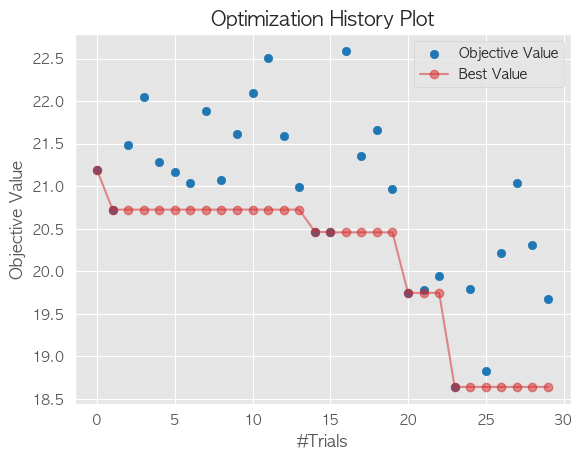

In [149]:
optuna.visualization.matplotlib.plot_optimization_history(studyLGBM)

/var/folders/nd/cl2nzwh13zx7jdly2t5m95340000gn/T/ipykernel_28368/4061365106.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(studyLGBM) # 파라미터 중요도 확인 그래프


<AxesSubplot:title={'center':'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

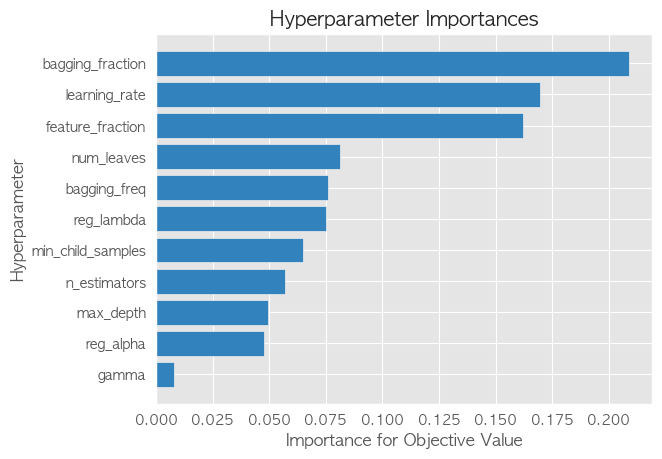

In [150]:
optuna.visualization.matplotlib.plot_param_importances(studyLGBM) # 파라미터 중요도 확인 그래프

/var/folders/nd/cl2nzwh13zx7jdly2t5m95340000gn/T/ipykernel_28368/1873634803.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(studyLGBM)


array([<AxesSubplot:xlabel='bagging_fraction', ylabel='Objective Value'>,
       <AxesSubplot:xlabel='bagging_freq'>,
       <AxesSubplot:xlabel='feature_fraction'>,
       <AxesSubplot:xlabel='gamma'>, <AxesSubplot:xlabel='learning_rate'>,
       <AxesSubplot:xlabel='max_depth'>,
       <AxesSubplot:xlabel='min_child_samples'>,
       <AxesSubplot:xlabel='n_estimators'>,
       <AxesSubplot:xlabel='num_leaves'>,
       <AxesSubplot:xlabel='reg_alpha'>,
       <AxesSubplot:xlabel='reg_lambda'>], dtype=object)

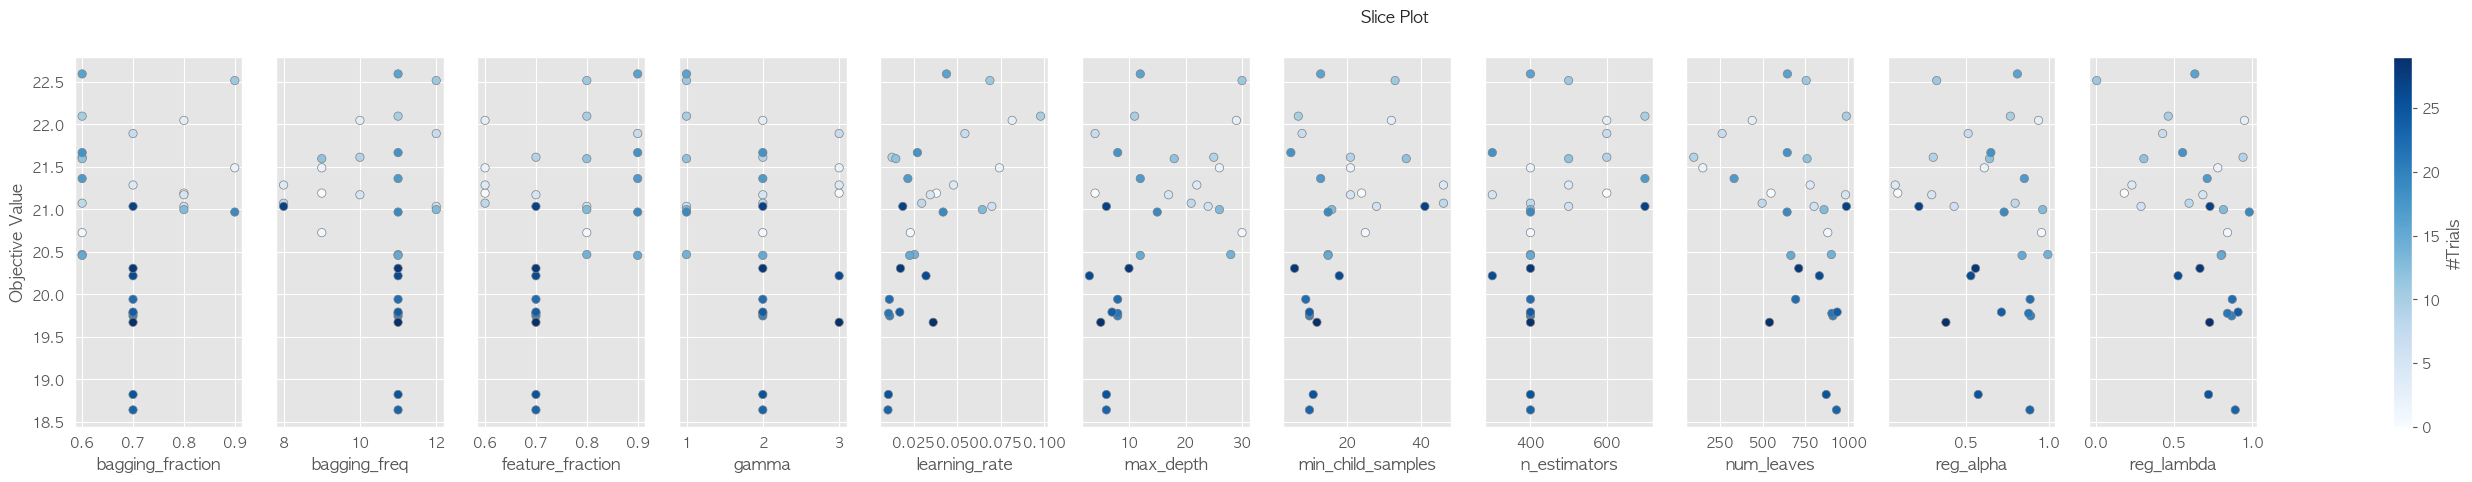

In [151]:
optuna.visualization.matplotlib.plot_slice(studyLGBM)

# LGBM

In [11]:
parameter ={'max_depth': 6,
 'num_leaves': 932,
 'min_child_samples': 10,
 'learning_rate': 0.010231008166953331,
 'n_estimators': 400,
 'reg_alpha': 0.887715014428123,
 'reg_lambda': 0.8916021771099598,
 'gamma': 2,
 'feature_fraction': 0.7,
 'bagging_fraction': 0.7,
 'bagging_freq': 11}


model = LGBMRegressor(**parameter)
model.fit(train_x, train_y, categorical_feature =CATEGORICAL_COLUMN, verbose=100)

/Users/keumhyeonjun/opt/anaconda3/envs/행안부/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


LGBMRegressor(bagging_fraction=0.7, bagging_freq=11, feature_fraction=0.7,
              gamma=2, learning_rate=0.010231008166953331, max_depth=6,
              min_child_samples=10, n_estimators=400, num_leaves=932,
              reg_alpha=0.887715014428123, reg_lambda=0.8916021771099598)

In [12]:
predict_test = model.predict(test_x)
for i in range(len(predict_test)):
    if predict_test[i] < 0 :
        predict_test[i] = 0
    else :
        predict_test[i] = predict_test[i].round(0)
predict_test

array([0., 0., 0., ..., 0., 0., 0.])

In [13]:
MAE = mean_absolute_error(test_y, predict_test)
MAE_per = sum(abs(test_y - predict_test)) / sum(test_y) * 100
print('MAE =', MAE)
print('MAE_per =', MAE_per)
RMSE = np.sqrt(mean_squared_error(test_y, predict_test))
RMSE_per = (np.sqrt(np.mean(np.square((test_y - predict_test) / test_y)))) * 100
print('RMSE =', RMSE)
print('RMSE(per) =', RMSE_per)


MAE = 2.557510148849797
MAE_per = 110.07571345369831
RMSE = 4.327086854862794
RMSE(per) = inf


<AxesSubplot:xlabel='일시'>

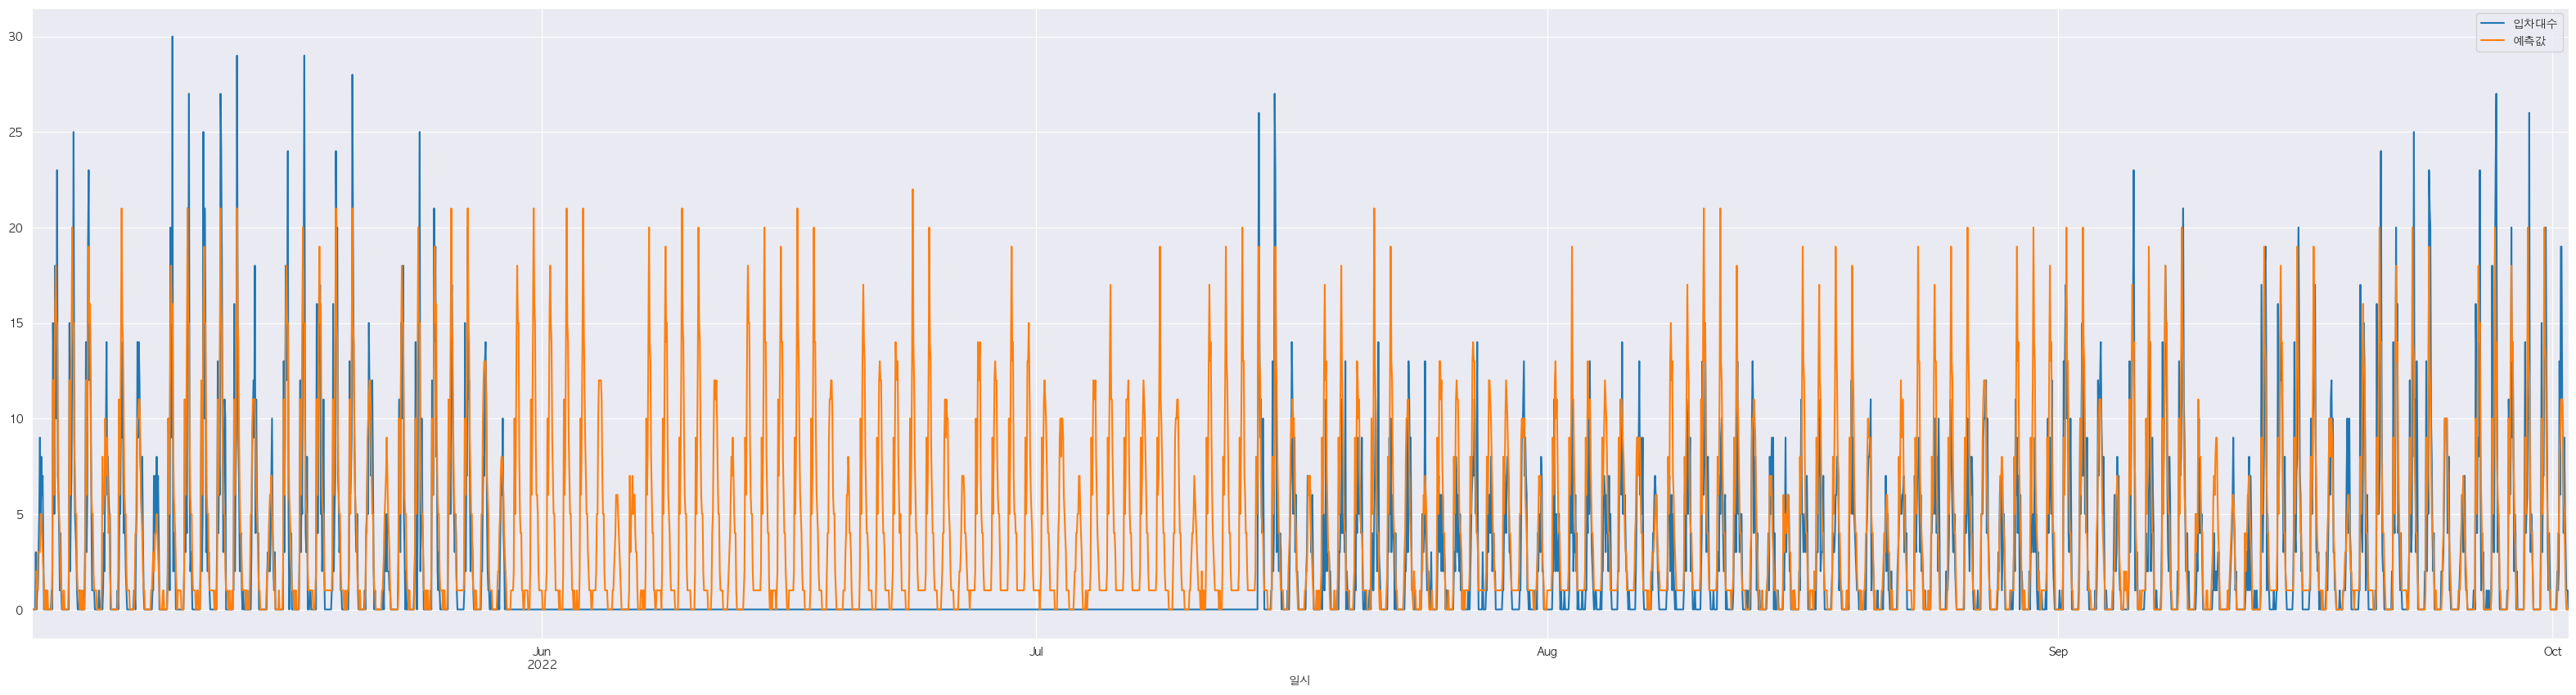

In [36]:
result = pd.concat([test_y, pd.Series(predict_test, index=test_y.index, name='예측값')], axis=1)
result.plot(figsize =(40,10))

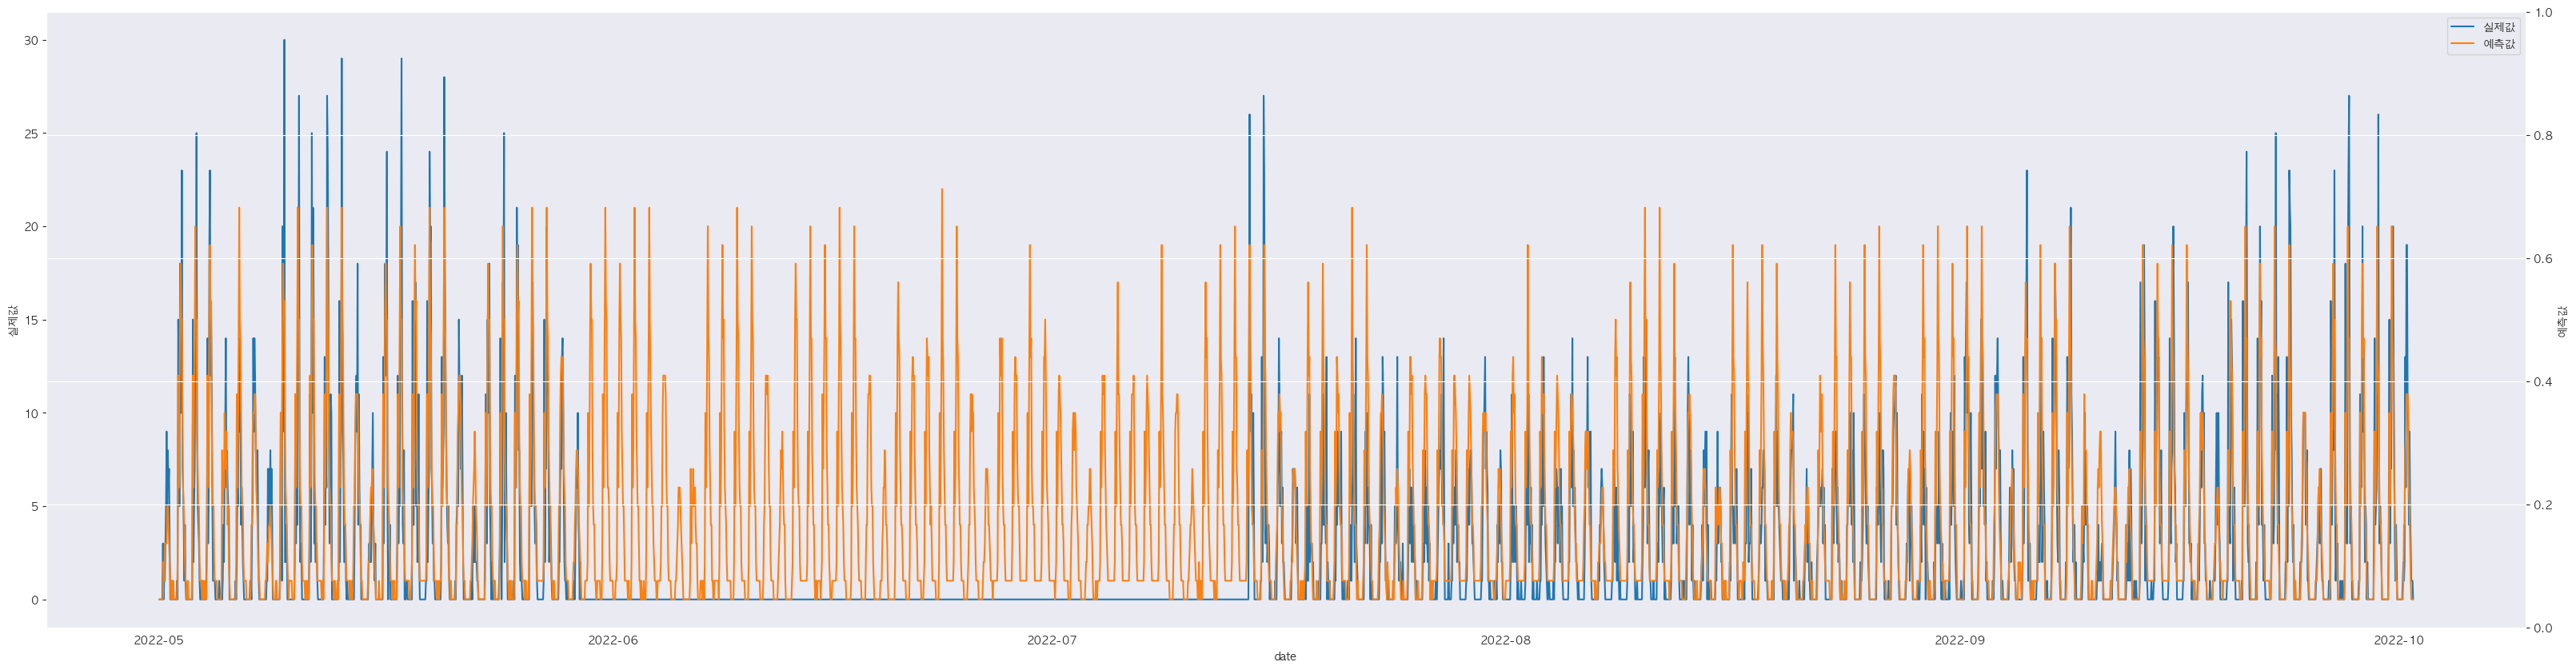

In [34]:
start = result.index[0]
end = result.index[-1]
result_plt = result.reset_index()
fig , ax1 = plt.subplots(figsize=(40,10))
ax2  = ax1.twinx()
lns1 = ax1.plot(result_plt['일시'],result_plt['입차대수'], label = '실제값')
lns2 = ax1.plot(result_plt['일시'],result_plt['예측값'], label = '예측값')
lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

ax1.grid()
ax1.set_xlabel('date')
ax1.set_ylabel('실제값')
ax2.set_ylabel('예측값')
plt.show()


In [157]:
result = pd.concat([test_y, pd.Series(predict_test, index=test_y.index, name='예측값')], axis=1)
#result.to_excel('결과_비정기권_주차1동,주차2동.xlsx')

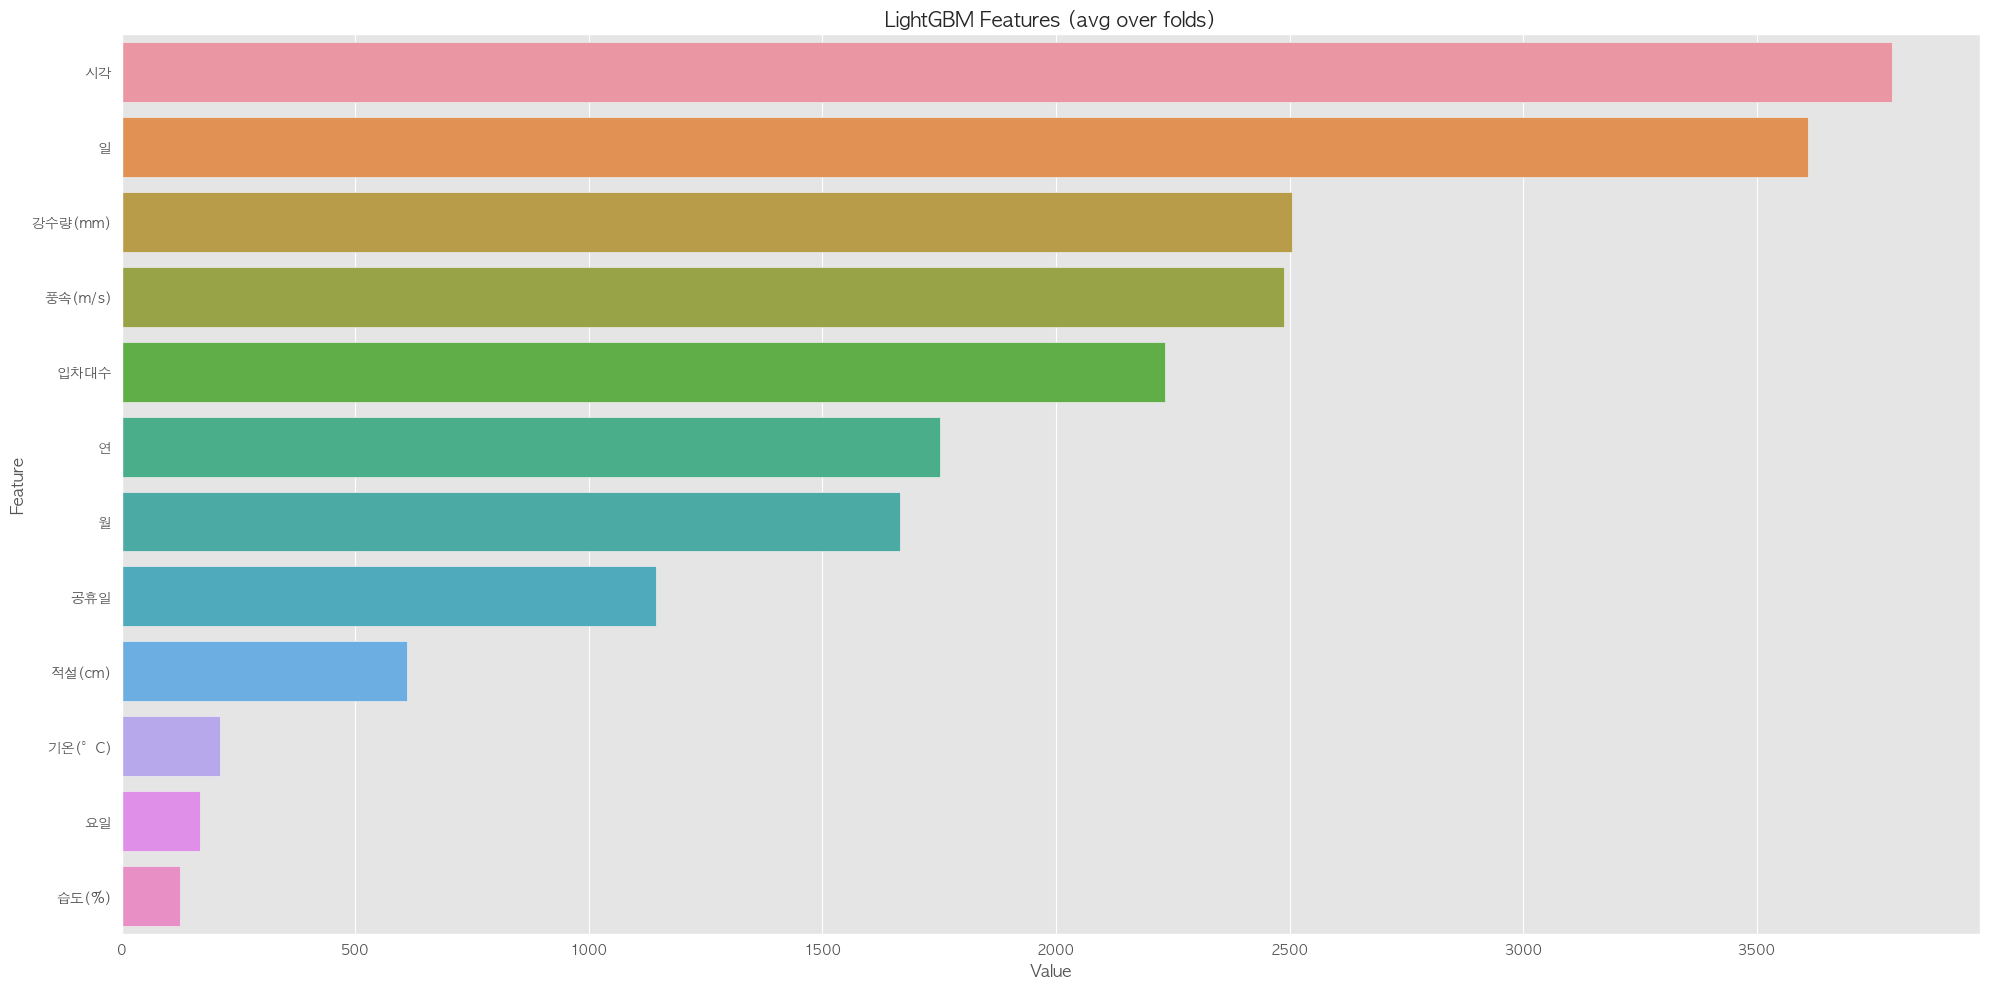

In [158]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,dataset.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [159]:
result

,입차대수,예측값
일시,,
2022-05-01 01:00:00,0.0,0.0
2022-05-01 02:00:00,0.0,0.0
2022-05-01 03:00:00,0.0,0.0
2022-05-01 04:00:00,0.0,0.0
2022-05-01 05:00:00,0.0,0.0
...,...,...
2022-10-01 19:00:00,3.0,1.0
2022-10-01 20:00:00,1.0,0.0
2022-10-01 21:00:00,1.0,0.0
